In [2]:
import wfdb
import subprocess
import os
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

if not os.path.exists('data/afdb-1.0.0.physionet.org/'):
    subprocess.Popen('gsutil -m cp -r gs://afdb-1.0.0.physionet.org ./data/', shell=True, stdout=subprocess.PIPE).wait()

ModuleNotFoundError: No module named 'seaborn'

In [19]:
all_files = ['00735', '03665', '04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091','05121','05261', '06426',
             '06453', '06995', '07162','07859','07879','07910','08215','08219','08378','08405','08434','08455']
good_annotated = ['04043', '04048', '04746', '05261', '06995', '07879', '07910','08219']

not_R_peaks = ['04015', '04126', '04908', '04936', '05091', '05121', '06426', '06453', '08215', '08455', '08434', '08378'] # maybe second graph better
bad_annotated = ['07162', '07859', '08405']
no_record = ['00735', '03665']
fine_files = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091','05121','05261', '06426',
             '06453', '06995', '07162','07859','07879','07910','08215','08219','08378','08405','08434','08455']


00735
sampto must be shorter than the signal length
03665
sampto must be shorter than the signal length
04015


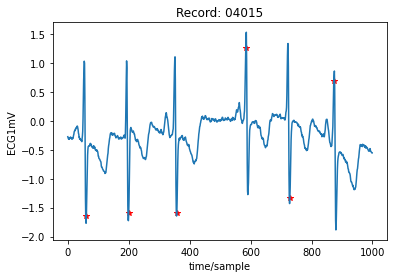

04043


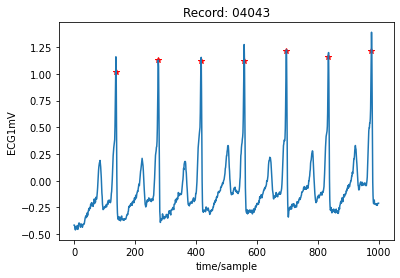

04048


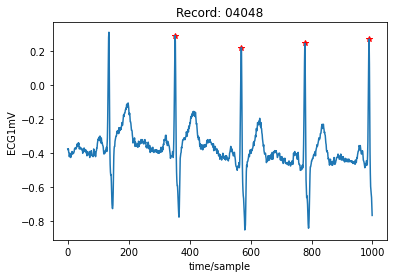

04126


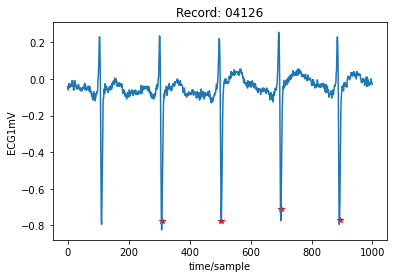

04746


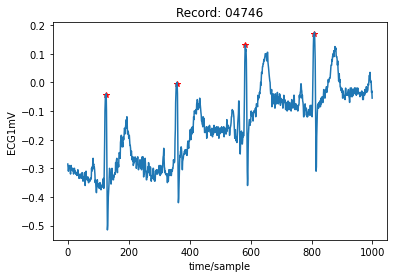

04908


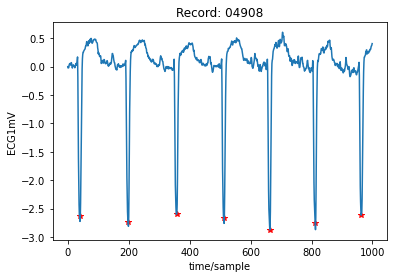

04936


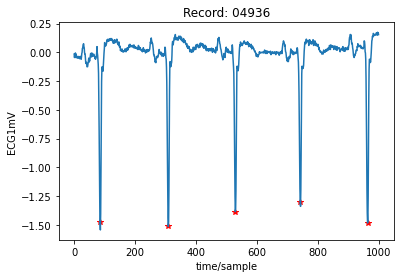

05091


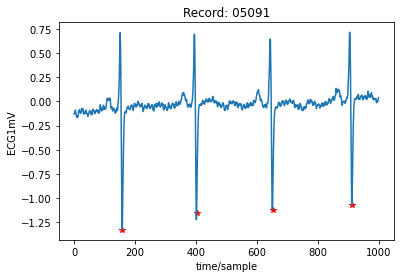

05121


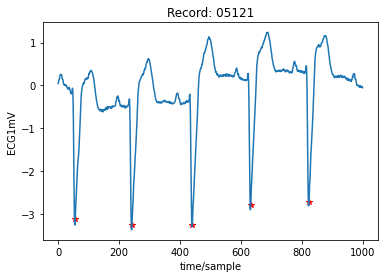

05261


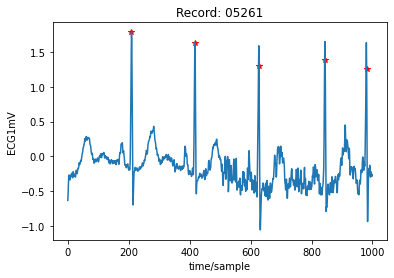

06426


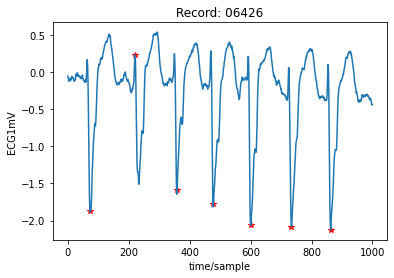

06453


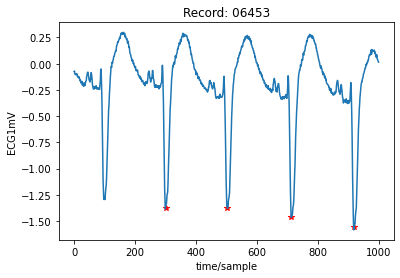

06995


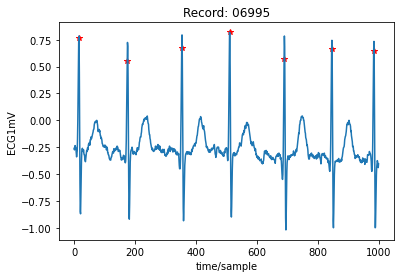

07162


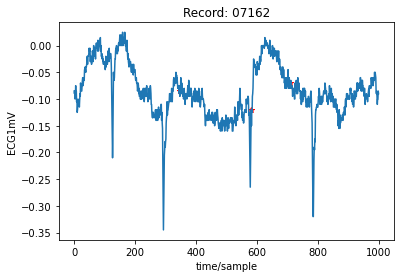

07859


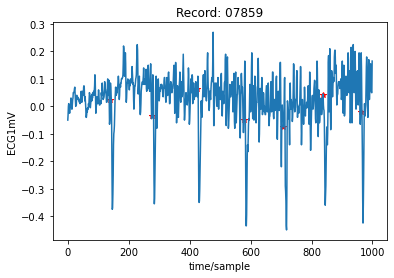

07879


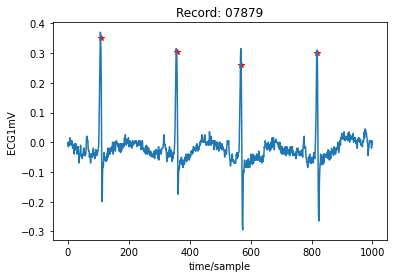

07910


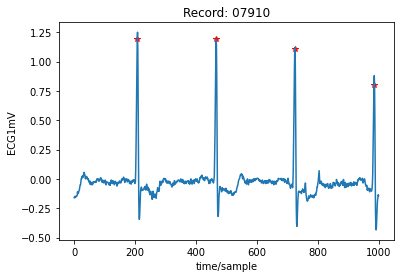

08215


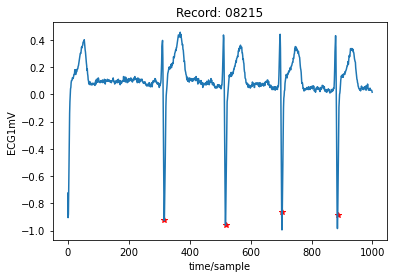

08219


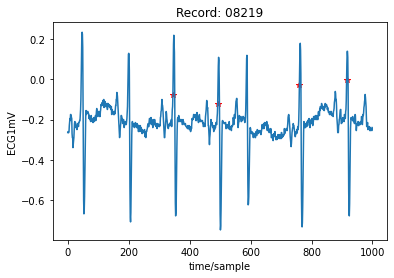

08378


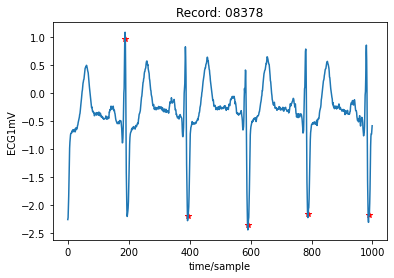

08405


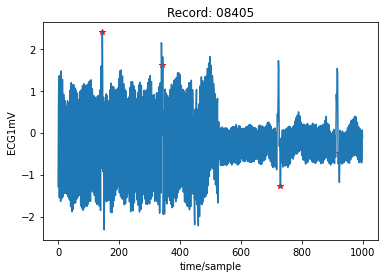

08434


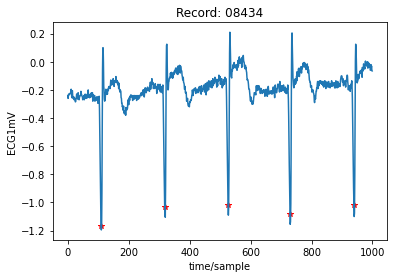

08455


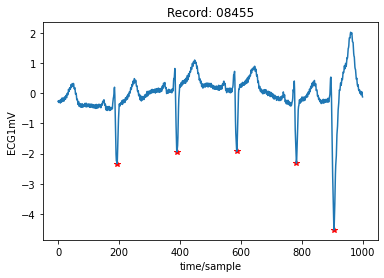

In [20]:
# find files that annotated correctly
for file in all_files:
    print(file)
    try:
        record = wfdb.rdrecord(f'data/afdb-1.0.0.physionet.org/{file}',sampfrom=0, sampto=1000, channels = [0])
        beats = wfdb.rdann(f'data/afdb-1.0.0.physionet.org/{file}','qrs', sampfrom=0, sampto=1000,  shift_samps=True)
        af = wfdb.rdann(f'data/afdb-1.0.0.physionet.org/{file}','atr', sampfrom=0, sampto=1000, shift_samps=True)
        wfdb.plot_wfdb(record, annotation = beats)
    except Exception as e:
        print(e)



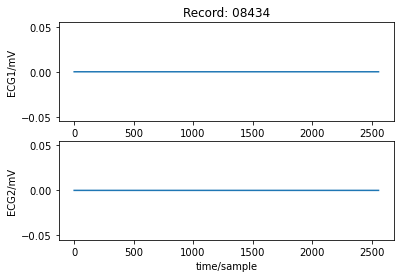

In [21]:
flat_signal_file = '08434'
start_flat_time_minutes = 151
stop_flat_time_minutes = 152
samples_per_minute = 15000
#record = wfdb.rdrecord(f'data/afdb-1.0.0.physionet.org/{flat_signal_file}', sampfrom=start_flat_time_minutes * samples_per_minute, sampto=stop_flat_time_minutes * samples_per_minute)
record = wfdb.rdrecord(f'data/afdb-1.0.0.physionet.org/{flat_signal_file}', sampfrom=2278400, sampto=2280960)
#ann = wfdb.rdann(f'data/afdb-1.0.0.physionet.org/{flat_signal_file}','atr', sampfrom=start_flat_time_minutes * samples_per_minute, sampto=stop_flat_time_minutes * samples_per_minute,shift_samps=True)
wfdb.plot_wfdb(record)

In [3]:
def ann_to_afibs(ann):
    ann_time = ann.sample
    ann_type = np.array(ann.aux_note)
    afib_times = ann_time[ann_type == '(AFIB']
    return afib_times


In [23]:
for file in good_annotated:
    try:
        #file_name = f'data/afdb-1.0.0.physionet.org/{file}'
        #process_data_file(file_name)
        break
    except Exception as e:
        #print(e)
        pass

In [4]:
def process_data_file(file_name):
        # record = wfdb.rdrecord(file_name,sampfrom=0, sampto=1000, channels = [0])
        beats = wfdb.rdann(file_name,'qrs', shift_samps=True)
        af = wfdb.rdann(file_name,'atr', shift_samps=True)
        af_time = ann_to_afibs(af)
        beats_time = beats.sample
        num_of_beats = len(beats_time)
        #for i in range(num_of_beats - 100): # validate actually taking all data and corect size of sequences
        for i in range(200):
            sequence_start = beats_time[i]
            sequence_end = beats_time[i + 100]
            af_sequence = (sequence_start < af_time) & (sequence_end > af_time)
            is_sequence_af = 0 if af_sequence.sum() == 0 else 1
            record = wfdb.rdrecord(file_name,sampfrom=sequence_start, sampto=sequence_end, channels = [0])
            sequence = record.p_signal
            sequence = np.append(sequence,is_sequence_af)
            


In [79]:
import utils
from imblearn.over_sampling import SMOTE



def record_to_100_beats(file_name, out_name):

    af_count = 0
    non_af_count = 0
    oversample = SMOTE(sampling_strategy=0.1)
    
    beats = wfdb.rdann(file_name,'qrs', shift_samps=True) 
    af = wfdb.rdann(file_name,'atr', shift_samps=True) 
    af_time = ann_to_afibs(af)

    beats_time = beats.sample
    num_of_beats = len(beats_time)
    lengths = []
    af_in_beats = []
    for i in range(1, num_of_beats):
        lengths.append(beats_time[i] - beats_time[i - 1])
        af_sequence = (beats_time[i - 1] < af_time) & (beats_time[i] > af_time)
        is_sequence_af = 0 if af_sequence.sum() == 0 else 1
        x = af_sequence.sum()
        if x == 0:
            non_af_count += 1
        else:
            af_count += x
        af_in_beats.append(is_sequence_af)



    np_lengths = np.array(lengths)
    af_np = np.array(af_in_beats)
    #outs = np_lengths[(np_lengths > (mean + 3 * sd)) | (np_lengths < (mean - 3 * sd))]
    
    # remove HR samples that are over 200 or below 50
    af_clean = af_np[(np_lengths < 300) & (np_lengths > 75)]
#     unique, counts = np.unique(af_clean, return_counts=True)
#     print(dict(zip(unique, counts)))

    #print("removing lengths:")
#     try:
#         lengths_over, af_in_beats_over = oversample.fit_resample(np_lengths.reshape(-1, 1), af_clean)
#         np_lengths = lengths_over.reshape(1, -1)[0]
#         af_clean = af_in_beats_over
#     except:
#         pass

    #unique, counts = np.unique(af_clean, return_counts=True)
    #print(dict(zip(unique, counts)))
    #print(af_np[(np_lengths < 300) & (np_lengths > 75)])
    np_lengths_clean = np_lengths[(np_lengths < 300) & (np_lengths > 75)] 
    p = len(np_lengths_clean) / len(np_lengths)
    #print(f"percent of data cleaned : {1 - p}")

    hr_samples = utils.samples_length_to_array(np_lengths_clean)
    sd = np.std(hr_samples)
    mean = np.mean(hr_samples)
#     print(f"mean hr : {mean}")
#     print(f"min hr : {min(hr_samples)}")
#     print(f"max hr : {max(hr_samples)}")
#     print(f"sd in hr: {sd}")

    #sns.displot(out_af)
    try:
        _, counts = np.unique(af_np, return_counts=True)
#         print(counts)
#         print(f"Ratio between af labels : {counts[1] / (counts[1] + counts[0])}")

        _, counts = np.unique(af_clean, return_counts=True)
#         print(counts)
#         print(f"Ratio between af labels : {counts[1] / (counts[1] + counts[0])}")
    except:
        pass
   
    
    # generate csv
    data = []
    af_new = 0
    for i in range(len(np_lengths_clean) - 100):
        af = [1 if sum(af_clean[i : i + 100]) > 0 else 0]
        af_new += af[0]
#         display(af)
        seq = list(np_lengths_clean[i : i + 100]) + af 
#         display(seq)
        data.append(seq)
    df = pd.DataFrame(data)

    df.to_csv(out_name, index=False, header=False)
    return af_count, non_af_count

In [81]:
fine_files = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091','05121','05261', '06426',
             '06453', '06995', '07162','07859','07879','07910','08215','08219','08378','08405','08434','08455']
af = 0
non_af = 0

for file in fine_files:
    file_name = f'../data/afdb-1.0.0.physionet.org/{file}'
    out_name = f'../data/proccessed_cleaned/{file}.csv'
    af_cur, non_af_cur = record_to_100_beats(file_name, out_name)
    af += af_cur
    non_af += non_af_cur
print(af)
print(non_af)
    
    

287
1128251


Lets load as tensors the training and test set

TEST SET